In [1]:
import os, seaborn as sns, pandas as pd, numpy as np, matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('final_acc_report.csv')

### The dataset was cleared, translated from arabic and got the dummies earlier. 
#### Refer to :https://github.com/khairy84/classification-for-Abu-Dhabi-Traffic-Accident-Data

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc

### Correlation

In [4]:
inj = (data['with injuries'] == 1).astype(int)
fields = list(data.drop('with injuries', axis=1))
correlations = data[fields].corrwith(inj)
correlations.sort_values(inplace=True)
correlations

paved Surface                                                                 -0.509712
fine weather                                                                  -0.049058
The type of incident is consumed                                              -0.048080
Causes Back without attention                                                 -0.036134
The type of incident is shocked                                               -0.027604
                                                                                 ...   
Reasons not to give priority to cross infantry                                 0.136413
Speed causes without taking into account road conditions                       0.157144
The reasons for the road while driving the vehicle in any picture they were    0.299938
The type of incident run over                                                  0.324538
unknown Surface condition                                                      0.528471
Length: 106, dtype: float64

In [5]:
correlations_sample = pd.concat([correlations.sort_values(ascending=False)[:15], correlations.sort_values(ascending=False)[-15:]])

In [6]:
correlations_sample

unknown Surface condition                                                      0.528471
The type of incident run over                                                  0.324538
The reasons for the road while driving the vehicle in any picture they were    0.299938
Speed causes without taking into account road conditions                       0.157144
Reasons not to give priority to cross infantry                                 0.136413
Reasons do not estimate the way users                                          0.107978
Reasons for driving without driving license at all                             0.106882
Type of incident deterioration                                                 0.093127
Reasons driving under impact or anesthetic                                     0.092150
Reasons for sudden deviation                                                   0.069645
The weather is cloudy                                                          0.067929
The reasons for garor are locate

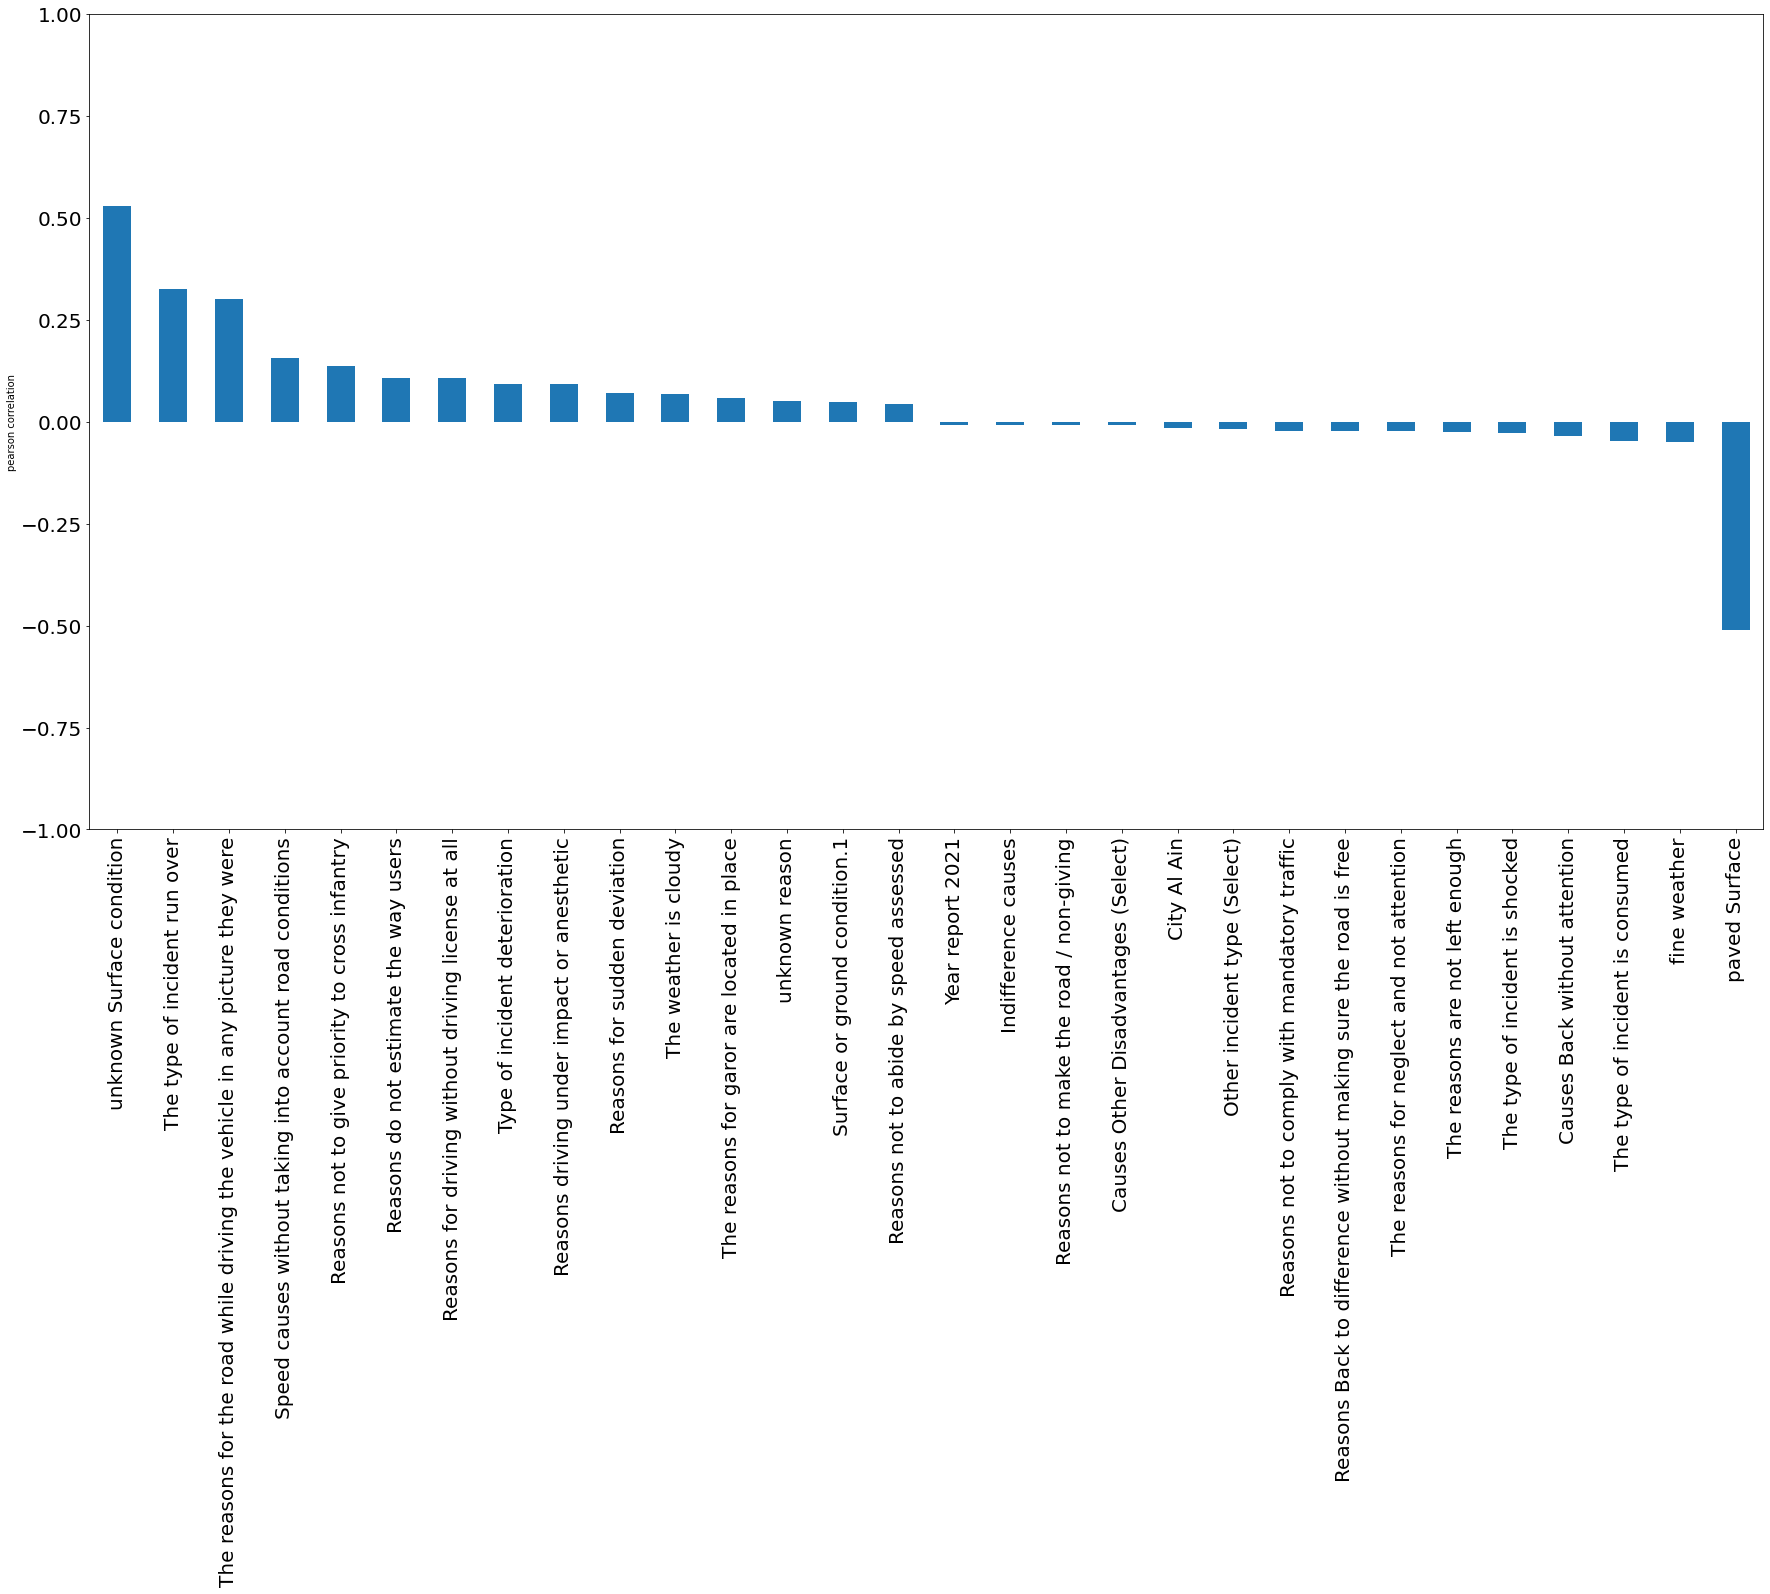

In [7]:
ax = correlations_sample.plot(kind='bar', figsize=(30,15), fontsize=20)
ax.set(ylim=[-1, 1], ylabel='pearson correlation');

In [18]:
corr_df = correlations_sample.index

<AxesSubplot:>

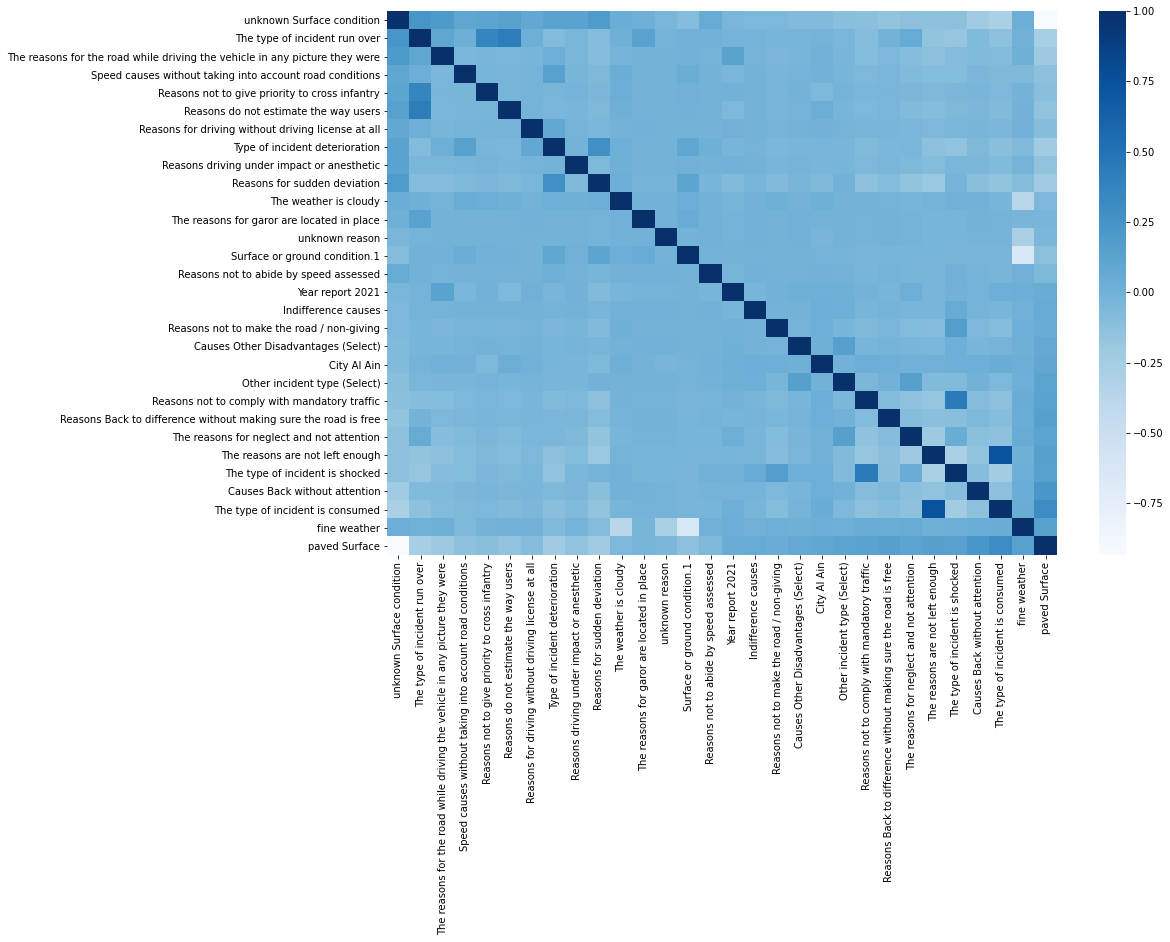

In [19]:
fig, ax = plt.subplots(figsize=(15,10)) 
sns.heatmap(df[corr_df].corr(), cmap='Blues')

In [8]:
# check if our traget is imbalanced or balanced
data['with injuries'].value_counts()

0    247604
1      2091
Name: with injuries, dtype: int64

### Model for inbalanced target

In [151]:
feature_cols = [x for x in data.columns if x not in 'with injuries']

In [168]:
from sklearn.model_selection import StratifiedShuffleSplit

# Split the data into two parts with 1000 points in the test data
# This creates a generator
strat_shuff_split = StratifiedShuffleSplit(n_splits=5, test_size=1000, random_state=42)

# Get the index values from the generator
train_idx, test_idx = next(strat_shuff_split.split(data[feature_cols], data['with injuries']))

# Create the data sets
X_train = data.loc[train_idx, feature_cols]
y_train = data.loc[train_idx, 'with injuries']

X_test = data.loc[test_idx, feature_cols]
y_test = data.loc[test_idx, 'with injuries']

In [169]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(max_depth= 29, max_features= 37, random_state=42)
dt = dt.fit(X_train, y_train)

In [170]:
dt.tree_.node_count, dt.tree_.max_depth

(1961, 29)

In [171]:
def measure_error(y_true, y_pred, label):
    return pd.Series({'accuracy':accuracy_score(y_true, y_pred),
                      'precision': precision_score(y_true, y_pred),
                      'recall': recall_score(y_true, y_pred),
                      'f1': f1_score(y_true, y_pred)},
                      name=label)

In [172]:
y_train_pred = dt.predict(X_train)
y_test_pred = dt.predict(X_test)

train_test_full_error = pd.concat([measure_error(y_train, y_train_pred, 'train'),
                              measure_error(y_test, y_test_pred, 'test')],
                              axis=1)

train_test_full_error

,train,test
accuracy,0.996003,0.996000
precision,0.810965,0.833333
recall,0.681709,0.625000
f1,0.740741,0.714286


In [173]:
y_pred = dt.predict(X)
y_scores = dt.predict_proba(X)[:, 1]
fpr, tpr, auc_thresholds = roc_curve(y, 
                                     y_scores, 
                                     pos_label=1)

# these two return different values
roc_auc = auc(fpr, tpr)
roc_auc_score(y, y_pred), roc_auc

(0.8405069344811096, 0.9935911026761546)

In [115]:
from sklearn.model_selection import GridSearchCV

param_grid = {'max_depth':range(1, dt.tree_.max_depth+1, 2),
              'max_features': range(1, len(dt.feature_importances_)+1)}

GR = GridSearchCV(DecisionTreeClassifier(random_state=42),
                  param_grid=param_grid,
                  scoring='accuracy',
                  n_jobs=-1)

GR = GR.fit(X_train, y_train)

In [126]:
GR.best_params_

{'max_depth': 29, 'max_features': 37}

In [116]:
GR.best_estimator_.tree_.node_count, GR.best_estimator_.tree_.max_depth

(1961, 29)

In [117]:
y_train_pred_gr = GR.predict(X_train)
y_test_pred_gr = GR.predict(X_test)

train_test_gr_error = pd.concat([measure_error(y_train, y_train_pred_gr, 'train'),
                                 measure_error(y_test, y_test_pred_gr, 'test')],
                                axis=1)
train_test_gr_error

,train,test
accuracy,0.996003,0.996000
precision,0.810965,0.833333
recall,0.681709,0.625000
f1,0.740741,0.714286


### Downsize the dataset to balance our target

In [4]:
n = 2091
sample_yes = data[data['with injuries'] == 1].sample(n=n, replace=False, random_state=0)
sample_no = data[data['with injuries'] == 0].sample(n=n, replace=False, random_state=0)
df = pd.concat([sample_yes, sample_no])

In [5]:
y, X = df['with injuries'], df.drop(columns='with injuries')

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [12]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=42)
dt = dt.fit(X_train, y_train)

In [122]:
dt.tree_.node_count, dt.tree_.max_depth

(333, 25)

In [144]:
def measure_error(y_true, y_pred, label):
    return pd.Series({'accuracy':accuracy_score(y_true, y_pred),
                      'precision': precision_score(y_true, y_pred),
                      'recall': recall_score(y_true, y_pred),
                      'f1': f1_score(y_true, y_pred),
                      'auc' : roc_auc_score(y_true, y_pred)},
                      name=label)

In [145]:
y_train_pred = dt.predict(X_train)
y_test_pred = dt.predict(X_test)

train_test_full_error = pd.concat([measure_error(y_train, y_train_pred, 'train'),
                              measure_error(y_test, y_test_pred, 'test')],
                              axis=1)

train_test_full_error

,train,test
accuracy,0.979673,0.955768
precision,0.989274,0.962085
recall,0.969281,0.950820
f1,0.979175,0.956419
auc,0.979530,0.955874


In [146]:
from sklearn.model_selection import GridSearchCV

param_grid = {'max_depth':range(1, dt.tree_.max_depth+1, 2),
              'max_features': range(1, len(dt.feature_importances_)+1)}

GR = GridSearchCV(DecisionTreeClassifier(random_state=42),
                  param_grid=param_grid,
                  scoring='accuracy',
                  n_jobs=-1)

GR = GR.fit(X_train, y_train)

In [147]:
GR.best_params_

{'max_depth': 9, 'max_features': 44}

In [148]:
GR.best_estimator_.tree_.node_count, GR.best_estimator_.tree_.max_depth

(81, 9)

In [150]:
y_train_pred_gr = GR.predict(X_train)
y_test_pred_gr = GR.predict(X_test)

train_test_gr_error = pd.concat([measure_error(y_train, y_train_pred_gr, 'train'),
                                 measure_error(y_test, y_test_pred_gr, 'test')],
                                axis=1)
train_test_gr_error

,train,test
accuracy,0.960941,0.955170
precision,0.987169,0.980271
recall,0.932902,0.930913
f1,0.959268,0.954955
auc,0.960555,0.955689


### Bagging Random Forest Model

In [20]:
from sklearn.ensemble import RandomForestClassifier

In [38]:
RF = RandomForestClassifier(oob_score=True, 
                            random_state=42, 
                            warm_start=True,
                            n_jobs=-1)


In [39]:
oob_list = list()

# Iterate through all of the possibilities for 
# number of trees
for n_trees in [15, 20, 30, 40, 50, 100, 150, 200, 300, 400]:
    
    # Use this to set the number of trees
    RF.set_params(n_estimators=n_trees)

    # Fit the model
    RF.fit(X_train, y_train)

    # Get the oob error
    oob_error = 1 - RF.oob_score_
    
    # Store it
    oob_list.append(pd.Series({'n_trees': n_trees, 'oob': oob_error}))

rf_oob_df = pd.concat(oob_list, axis=1).T.set_index('n_trees')


C:\Users\USER7\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:541: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\USER7\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:545: RuntimeWarning: invalid value encountered in true_divide
  decision = (predictions[k] /


In [40]:
rf_oob_df.sort_values(by='oob')

,oob
n_trees,
100.0,0.041849
150.0,0.041849
200.0,0.042248
300.0,0.042248
400.0,0.043842
20.0,0.044241
40.0,0.045038
30.0,0.045436
50.0,0.046632


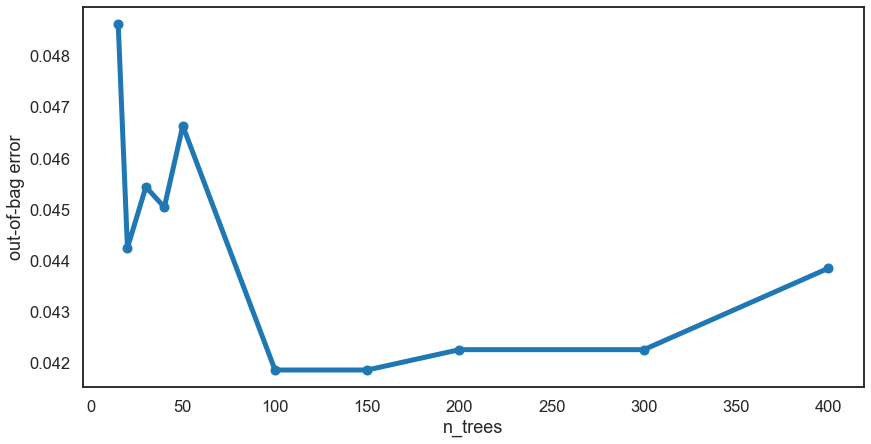

In [41]:
sns.set_context('talk')
sns.set_style('white')

ax = rf_oob_df.plot(legend=False, marker='o', figsize=(14, 7), linewidth=5)
ax.set(ylabel='out-of-bag error');

In [44]:
model = RF.set_params(n_estimators=100)

y_pred = model.predict(X_test)

In [45]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score
cr = classification_report(y_test, y_pred)
print(cr)

score_df = pd.DataFrame({'accuracy': accuracy_score(y_test, y_pred),
                         'precision': precision_score(y_test, y_pred),
                         'recall': recall_score(y_test, y_pred),
                         'f1': f1_score(y_test, y_pred),
                         'auc': roc_auc_score(y_test, y_pred)},
                         index=pd.Index([0]))

print(score_df)

              precision    recall  f1-score   support

           0       0.96      0.97      0.96       819
           1       0.97      0.96      0.97       854

    accuracy                           0.97      1673
   macro avg       0.97      0.97      0.97      1673
weighted avg       0.97      0.97      0.97      1673

   accuracy  precision    recall        f1       auc
0  0.965332   0.967136  0.964871  0.966002  0.965342


Text(0.5, 76.5, 'Ground Truth')

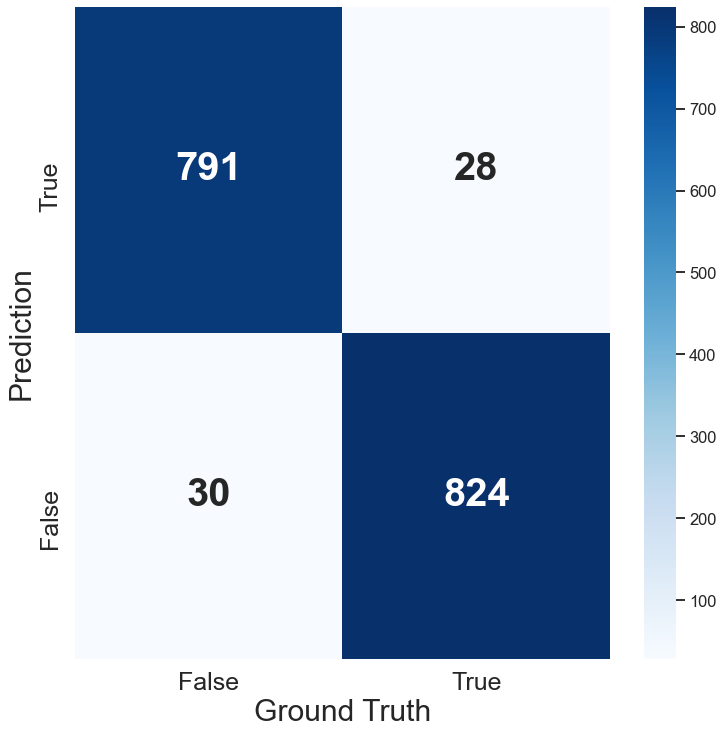

In [47]:
from sklearn.metrics import roc_curve, precision_recall_curve, confusion_matrix

sns.set_context('talk')
cm = confusion_matrix(y_test, y_pred)
_, ax = plt.subplots(figsize=(12,12))
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 40, "weight": "bold"})

labels = ['False', 'True']
ax.set_xticklabels(labels, fontsize=25);
ax.set_yticklabels(labels[::-1], fontsize=25);
ax.set_ylabel('Prediction', fontsize=30);
ax.set_xlabel('Ground Truth', fontsize=30)

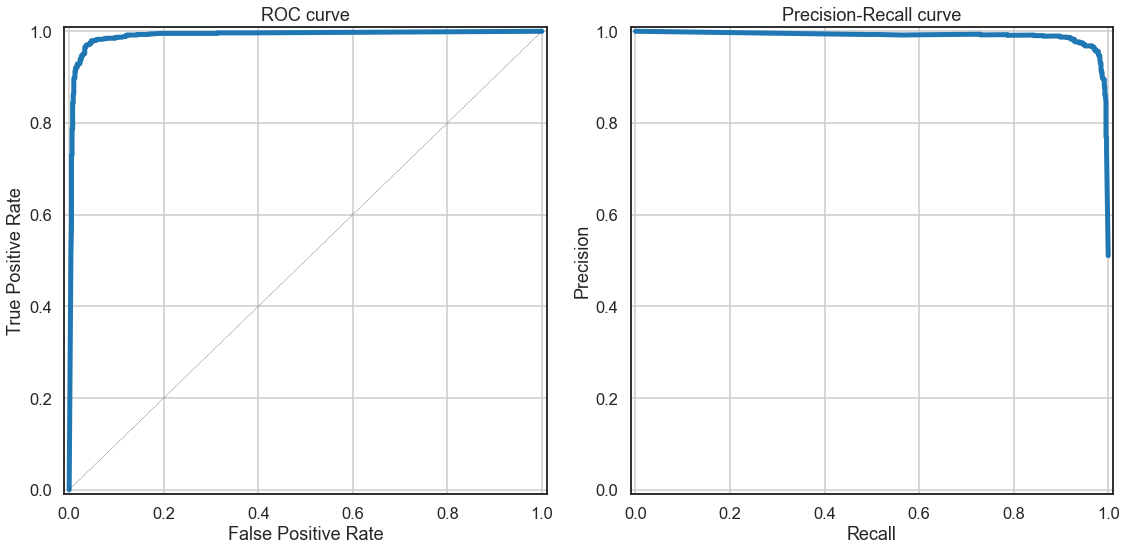

In [50]:
sns.set_context('talk')

fig, axList = plt.subplots(ncols=2)
fig.set_size_inches(16, 8)

# Get the probabilities for each of the two categories
y_prob = model.predict_proba(X_test)

# Plot the ROC-AUC curve
ax = axList[0]

fpr, tpr, thresholds = roc_curve(y_test, y_prob[:,1])
ax.plot(fpr, tpr, linewidth=5)
# It is customary to draw a diagonal dotted line in ROC plots.
# This is to indicate completely random prediction. Deviation from this
# dotted line towards the upper left corner signifies the power of the model.
ax.plot([0, 1], [0, 1], ls='--', color='black', lw=.3)
ax.set(xlabel='False Positive Rate',
       ylabel='True Positive Rate',
       xlim=[-.01, 1.01], ylim=[-.01, 1.01],
       title='ROC curve')
ax.grid(True)

# Plot the precision-recall curve
ax = axList[1]

precision, recall, _ = precision_recall_curve(y_test, y_prob[:,1])
ax.plot(recall, precision, linewidth=5)
ax.set(xlabel='Recall', ylabel='Precision',
       xlim=[-.01, 1.01], ylim=[-.01, 1.01],
       title='Precision-Recall curve')
ax.grid(True)

plt.tight_layout()

In [54]:
feature_cols = X.columns

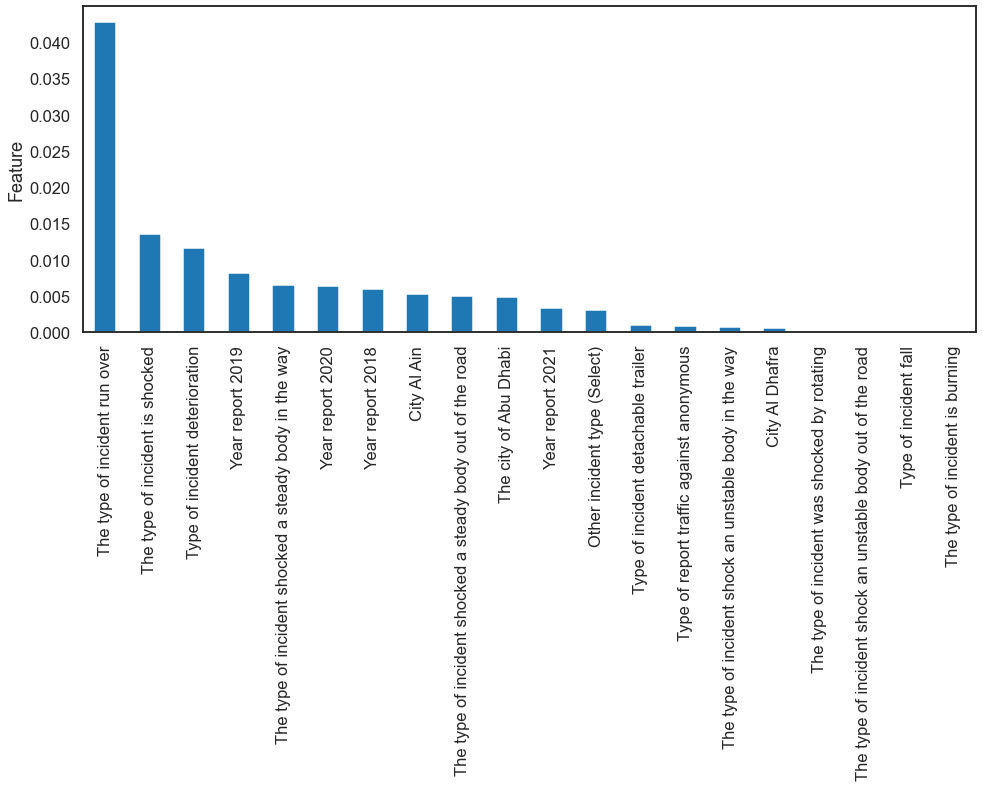

In [56]:
feature_imp = pd.Series(model.feature_importances_, index=feature_cols)[:20].sort_values(ascending=False)

ax = feature_imp.plot(kind='bar', figsize=(16, 6))
ax.set(ylabel='Relative Importance');
ax.set(ylabel='Feature');

In [62]:
from sklearn.ensemble import ExtraTreesClassifier

In [63]:
EF = ExtraTreesClassifier(oob_score=True, 
                          random_state=42, 
                          warm_start=True,
                          bootstrap=True,
                          n_jobs=-1)

In [64]:
oob_list = list()

# Iterate through all of the possibilities for 
# number of trees
for n_trees in [15, 20, 30, 40, 50, 100, 150, 200, 300, 400]:
    
    # Use this to set the number of trees
    EF.set_params(n_estimators=n_trees)
    EF.fit(X_train, y_train)

    # oob error
    oob_error = 1 - EF.oob_score_
    oob_list.append(pd.Series({'n_trees': n_trees, 'oob': oob_error}))

et_oob_df = pd.concat(oob_list, axis=1).T.set_index('n_trees')

C:\Users\USER7\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:541: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\USER7\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:545: RuntimeWarning: invalid value encountered in true_divide
  decision = (predictions[k] /


In [65]:
et_oob_df.sort_values(by='oob')

,oob
n_trees,
200.0,0.041849
150.0,0.042646
300.0,0.043045
400.0,0.043444
100.0,0.044241
50.0,0.046632
30.0,0.047429
20.0,0.048226
40.0,0.048226


In [66]:
model = EF.set_params(n_estimators=200)

y_pred = model.predict(X_test)

In [67]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score
cr = classification_report(y_test, y_pred)
print(cr)

score_df = pd.DataFrame({'accuracy': accuracy_score(y_test, y_pred),
                         'precision': precision_score(y_test, y_pred),
                         'recall': recall_score(y_test, y_pred),
                         'f1': f1_score(y_test, y_pred),
                         'auc': roc_auc_score(y_test, y_pred)},
                         index=pd.Index([0]))

print(score_df)

              precision    recall  f1-score   support

           0       0.97      0.96      0.97       819
           1       0.97      0.97      0.97       854

    accuracy                           0.97      1673
   macro avg       0.97      0.97      0.97      1673
weighted avg       0.97      0.97      0.97      1673

   accuracy  precision    recall        f1       auc
0  0.965929   0.966082  0.967213  0.966647  0.965902


Text(0.5, 76.5, 'Ground Truth')

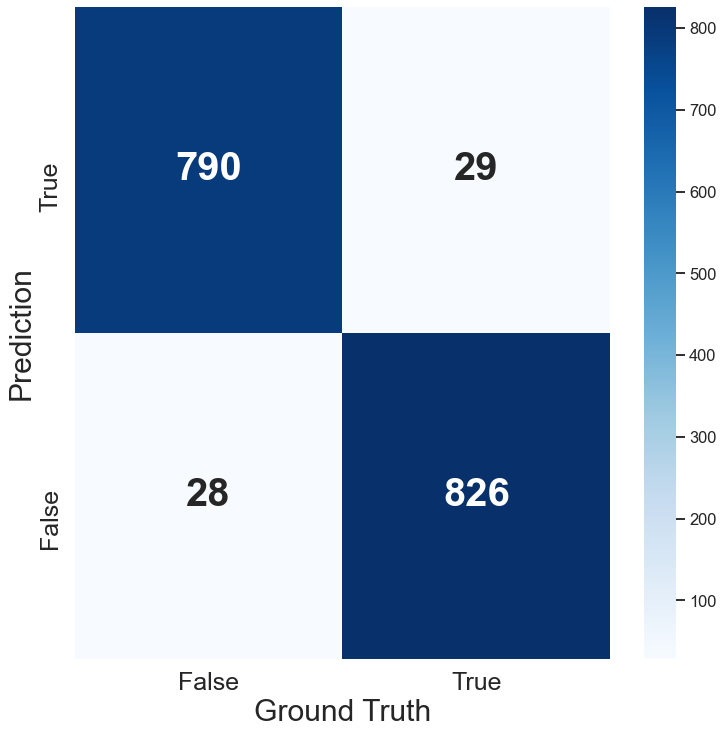

In [68]:
from sklearn.metrics import roc_curve, precision_recall_curve, confusion_matrix

sns.set_context('talk')
cm = confusion_matrix(y_test, y_pred)
_, ax = plt.subplots(figsize=(12,12))
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 40, "weight": "bold"})

labels = ['False', 'True']
ax.set_xticklabels(labels, fontsize=25);
ax.set_yticklabels(labels[::-1], fontsize=25);
ax.set_ylabel('Prediction', fontsize=30);
ax.set_xlabel('Ground Truth', fontsize=30)

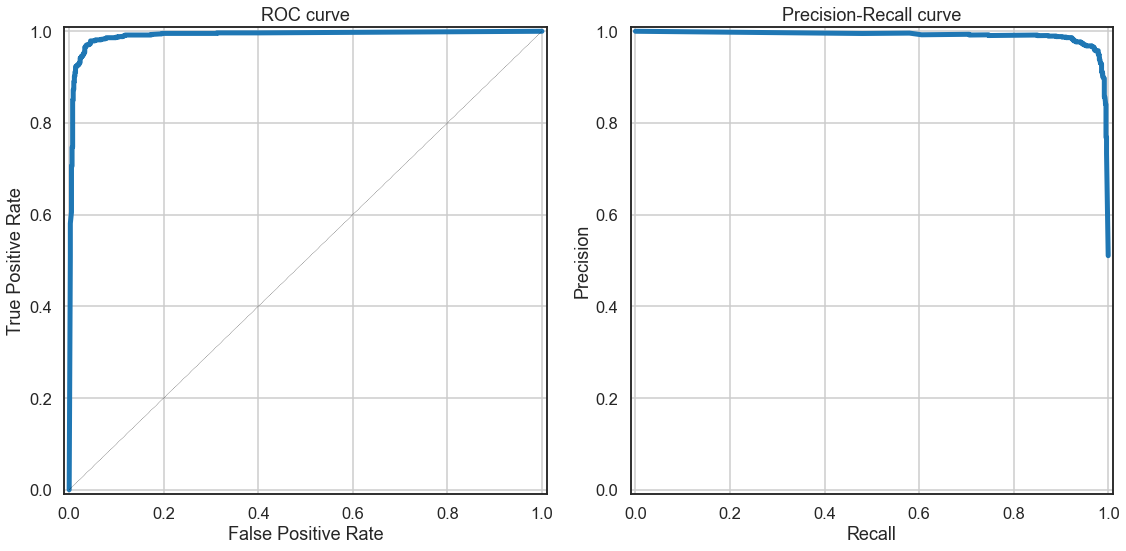

In [69]:
sns.set_context('talk')

fig, axList = plt.subplots(ncols=2)
fig.set_size_inches(16, 8)

# Get the probabilities for each of the two categories
y_prob = model.predict_proba(X_test)

# Plot the ROC-AUC curve
ax = axList[0]

fpr, tpr, thresholds = roc_curve(y_test, y_prob[:,1])
ax.plot(fpr, tpr, linewidth=5)
# It is customary to draw a diagonal dotted line in ROC plots.
# This is to indicate completely random prediction. Deviation from this
# dotted line towards the upper left corner signifies the power of the model.
ax.plot([0, 1], [0, 1], ls='--', color='black', lw=.3)
ax.set(xlabel='False Positive Rate',
       ylabel='True Positive Rate',
       xlim=[-.01, 1.01], ylim=[-.01, 1.01],
       title='ROC curve')
ax.grid(True)

# Plot the precision-recall curve
ax = axList[1]

precision, recall, _ = precision_recall_curve(y_test, y_prob[:,1])
ax.plot(recall, precision, linewidth=5)
ax.set(xlabel='Recall', ylabel='Precision',
       xlim=[-.01, 1.01], ylim=[-.01, 1.01],
       title='Precision-Recall curve')
ax.grid(True)

plt.tight_layout()

### Boosting and stacking

In [7]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

error_list = list()

# Iterate through various possibilities for number of trees
tree_list = [15, 25, 50, 100, 200, 400]
for n_trees in tree_list:
    
    # Initialize the gradient boost classifier
    GBC = GradientBoostingClassifier(n_estimators=n_trees, random_state=42)

    # Fit the model
    print(f'Fitting model with {n_trees} trees')
    GBC.fit(X_train.values, y_train.values)
    y_pred = GBC.predict(X_test)

    # Get the error
    error = 1.0 - accuracy_score(y_test, y_pred)
    
    # Store it
    error_list.append(pd.Series({'n_trees': n_trees, 'error': error}))

error_df = pd.concat(error_list, axis=1).T.set_index('n_trees')

error_df

Fitting model with 15 trees
Fitting model with 25 trees
Fitting model with 50 trees
Fitting model with 100 trees
Fitting model with 200 trees
Fitting model with 400 trees


,error
n_trees,
15.0,0.046025
25.0,0.042439
50.0,0.043634
100.0,0.032277
200.0,0.033473
400.0,0.034668


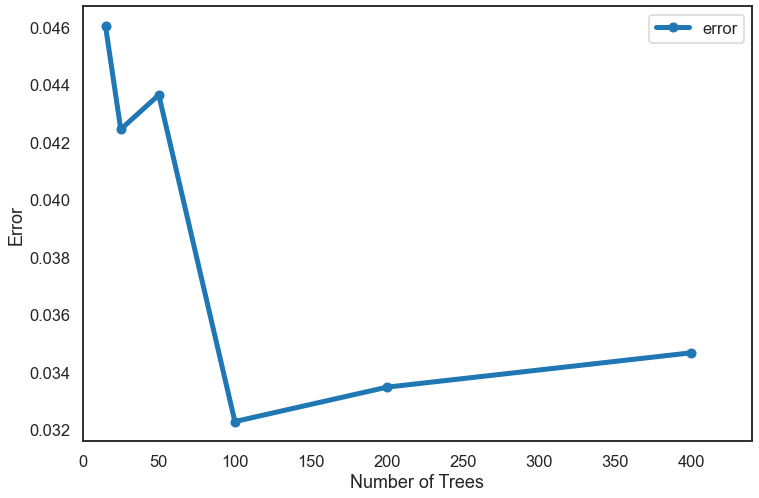

In [9]:
sns.set_context('talk')
sns.set_style('white')

# Create the plot
ax = error_df.plot(marker='o', figsize=(12, 8), linewidth=5)

# Set parameters
ax.set(xlabel='Number of Trees', ylabel='Error')
ax.set_xlim(0, max(error_df.index)*1.1);

In [10]:
from sklearn.model_selection import GridSearchCV

# The parameters to be fit
param_grid = {'n_estimators': tree_list,
              'learning_rate': [0.1, 0.01, 0.001, 0.0001],
              'subsample': [1.0, 0.5],
              'max_features': [1, 2, 3, 4]}

# The grid search object
GV_GBC = GridSearchCV(GradientBoostingClassifier(random_state=42), 
                      param_grid=param_grid, 
                      scoring='accuracy',
                      n_jobs=-1)

# Do the grid search
GV_GBC = GV_GBC.fit(X_train, y_train)

In [11]:
GV_GBC.best_estimator_

GradientBoostingClassifier(max_features=4, n_estimators=400, random_state=42,
                           subsample=0.5)

In [12]:
from sklearn.metrics import classification_report

y_pred = GV_GBC.predict(X_test)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97       834
           1       0.96      0.98      0.97       839

    accuracy                           0.97      1673
   macro avg       0.97      0.97      0.97      1673
weighted avg       0.97      0.97      0.97      1673



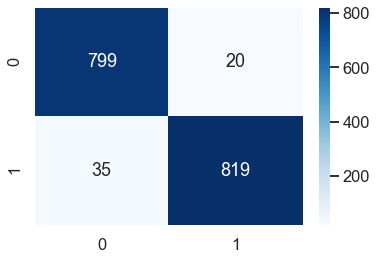

In [14]:
from sklearn.metrics import confusion_matrix

sns.set_context('talk')
cm = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

### AdaBoost model

In [15]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

ABC = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1))

param_grid = {'n_estimators': [100, 150, 200],
              'learning_rate': [0.01, 0.001]}

GV_ABC = GridSearchCV(ABC,
                      param_grid=param_grid, 
                      scoring='accuracy',
                      n_jobs=-1)

GV_ABC = GV_ABC.fit(X_train, y_train)

In [16]:
GV_ABC.best_estimator_

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.01, n_estimators=100)

In [17]:
y_pred = GV_ABC.predict(X_test)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.99      0.90      0.94       895
           1       0.90      0.99      0.94       778

    accuracy                           0.94      1673
   macro avg       0.94      0.94      0.94      1673
weighted avg       0.95      0.94      0.94      1673



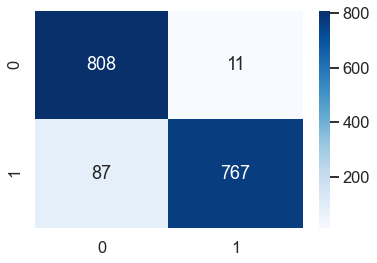

In [18]:
sns.set_context('talk')
cm = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

In [19]:
from sklearn.linear_model import LogisticRegression

# L2 regularized logistic regression
LR_L2 = LogisticRegression(penalty='l2', max_iter=500, solver='saga').fit(X_train, y_train)

In [20]:
y_pred = LR_L2.predict(X_test)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.98      0.95      0.97       842
           1       0.95      0.98      0.97       831

    accuracy                           0.97      1673
   macro avg       0.97      0.97      0.97      1673
weighted avg       0.97      0.97      0.97      1673



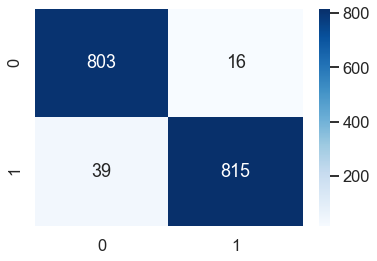

In [21]:
sns.set_context('talk')
cm = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

### Using Voting Classifier between GradientBoostingClassifier & LogisticRegression

In [22]:
from sklearn.ensemble import VotingClassifier

# The combined model--logistic regression and gradient boosted trees
estimators = [('LR_L2', LR_L2), ('GBC', GV_GBC)]

# Though it wasn't done here, it is often desirable to train 
# this model using an additional hold-out data set and/or with cross validation
VC = VotingClassifier(estimators, voting='soft')
VC = VC.fit(X_train, y_train)

In [25]:
VC

VotingClassifier(estimators=[('LR_L2',
                              LogisticRegression(max_iter=500, solver='saga')),
                             ('GBC',
                              GridSearchCV(estimator=GradientBoostingClassifier(random_state=42),
                                           n_jobs=-1,
                                           param_grid={'learning_rate': [0.1,
                                                                         0.01,
                                                                         0.001,
                                                                         0.0001],
                                                       'max_features': [1, 2, 3,
                                                                        4],
                                                       'n_estimators': [15, 25,
                                                                        50, 100,
                                                       

In [23]:
y_pred = VC.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       819
           1       0.98      0.96      0.97       854

    accuracy                           0.97      1673
   macro avg       0.97      0.97      0.97      1673
weighted avg       0.97      0.97      0.97      1673



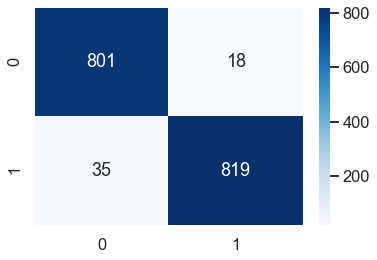

In [24]:
sns.set_context('talk')
cm = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')